In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve
import random
from sklearn.linear_model import SGDClassifier
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
def print_pr(y_test, y_predict):
    prec, rec, f_score, _ = precision_recall_fscore_support(y_test, y_predict, labels=[1])
    print('Precision = {:.3f}, Recall = {:.3f}, F-score = {:.3f}'.format(prec[0], rec[0], f_score[0]))

In [3]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# Предобработка данных

In [4]:
data = pd.read_csv('./data.csv')

In [5]:
data.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


In [6]:
print('Всего в выборке присутствуют записи о {} моторах'.format(np.unique(data['id']).size))

Всего в выборке присутствуют записи о 80 моторах


## Видоизменение исходных данных

id-шники моторов не нужны. Заместо них введём таргет, готорый будет равен 1 если цикл последний, и нулю в противном случае.

Также выделим 20 случайных моторов в тестовую выборку.

In [7]:
random.seed(17)
# добавляем target
last_cycles_idxs = []
for i, df in data.groupby(['id']):
    last_cycles_idxs.append(df.index[-1])

new_data = data.drop(columns=['id'])
new_data['target'] = np.zeros((len(data),))
new_data.iloc[last_cycles_idxs, -1] = 1

# train test split
idx_set = random.sample(range(1, 80), 20)
indices = data['id'] == idx_set[0]
for i in idx_set[1:]:
    indices = indices | (data['id'] == i)

train = new_data[~indices]
test = new_data[indices]

## Визуализация

Посмотрим можно ли разделить данные при понижении размерности.

In [8]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [9]:
%%time
features = train.iloc[:, :-1]
target = train['target']
embeddings = TSNE(n_jobs=-1).fit_transform(features)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

CPU times: user 1min 42s, sys: 133 ms, total: 1min 42s
Wall time: 30 s


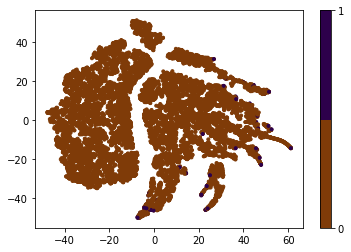

In [10]:
plt.scatter(vis_x, vis_y, c=target, cmap=plt.cm.get_cmap("PuOr", 2), marker='.')
plt.colorbar(ticks=range(2))
plt.show()

Видно чёткое разделение на 3 больших класса и несколько малых. При этом нельзя сказать, что точки отказов сильно отделимы от основной массы точек.

Посмотрим как классы связаны с id моторов

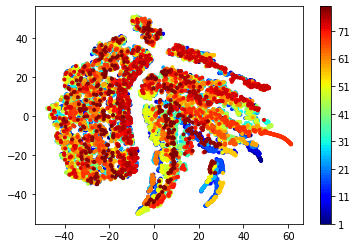

In [11]:
plt.scatter(vis_x, vis_y, c=data.id[~indices], cmap=plt.cm.get_cmap("jet", 80), marker='.')
plt.colorbar(ticks=range(1, 80, 10))
plt.show()

Похоже, что разделение по классам -- есть разделение по режимам работы двигателей.

Есть смысл изначально провести кластеризацию данных и затем определять риск отказа только при попадании в тот класс, в котором возможен отказ. Но для начала посмотрим, какие параметры вообще существенны.

<a id="data_preproc"></a>
## Отбор признаков

Посмотрим на распределения значений параметров по классам.

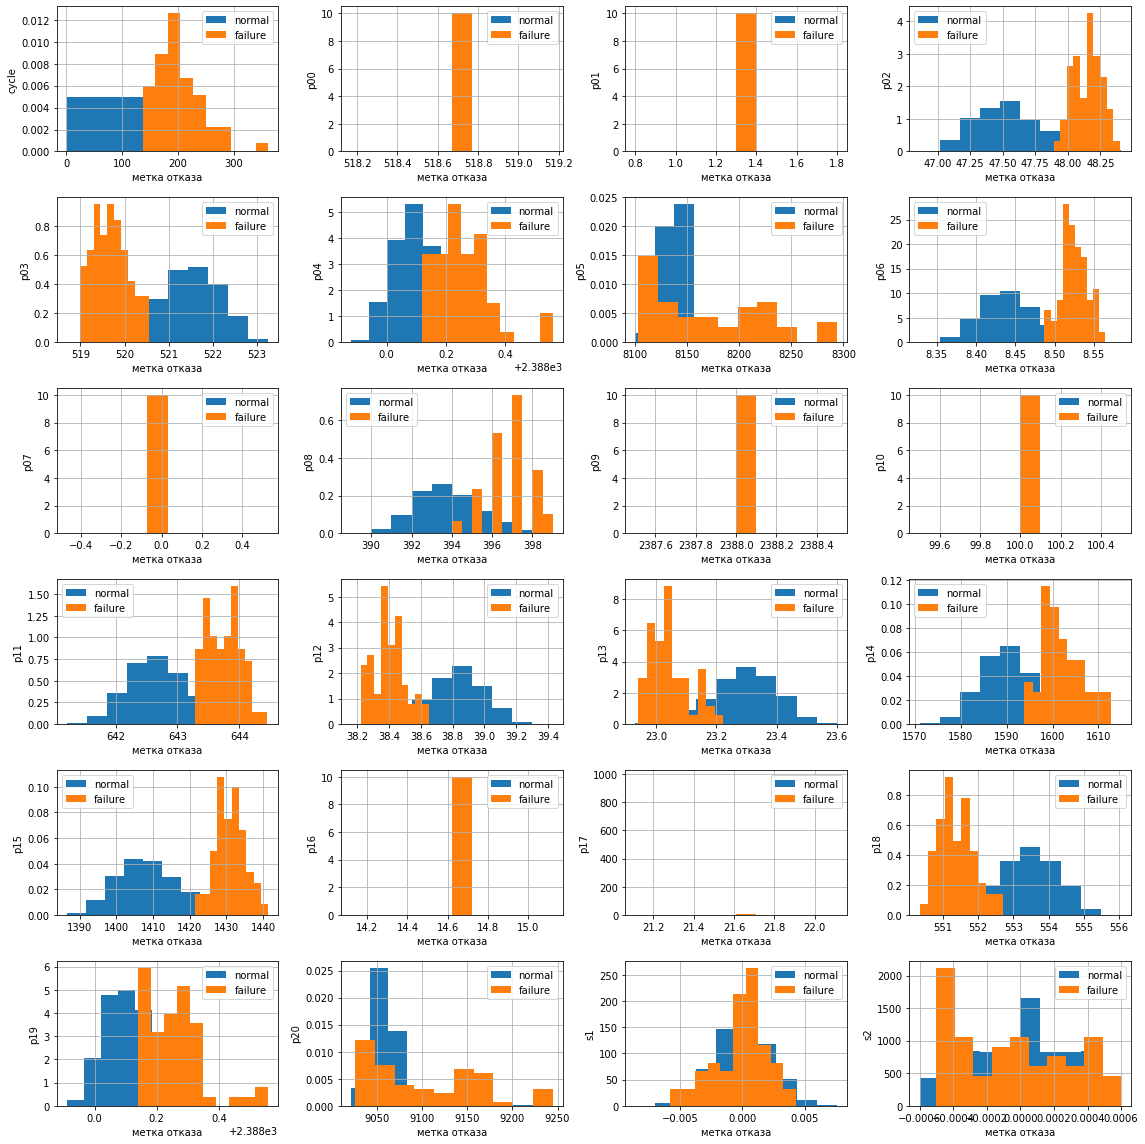

In [12]:
features_false = train[train['target'] == 0].iloc[:, :-1]
features_true = train[train['target'] == 1].iloc[:, :-1]
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 16))

# как вариант, можно и по-другому
for idx, col in enumerate(features_false.columns):
    ax = axes[idx // 4, idx % 4]
    features_false[col].hist(ax=ax, label='normal', density=True)
    features_true[col].hist(ax=ax, label='failure', density=True)
#     ax.plot([0, 1], [features_false[col].mean(), features_true[col].mean()])
    ax.set(xlabel='метка отказа', 
           ylabel=col)
    ax.legend()
fig.tight_layout()

Графики показывают, что параметры p00, p01, p07, p09, p10, p16, p17 можно исключить из рассмотрения так, как они вообще не исменяются. Также можно исключить из рассмотрения настройки после цикла.

In [13]:
false_columns = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 's1', 's2']
train.drop(columns=false_columns, inplace=True)
test.drop(columns=false_columns, inplace=True)
train.head()

,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p18,p19,p20,target
0,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,0.0
1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07,0.0
2,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,554.26,2388.08,9052.94,0.0
3,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,554.45,2388.11,9049.48,0.0
4,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,554.00,2388.06,9055.15,0.0


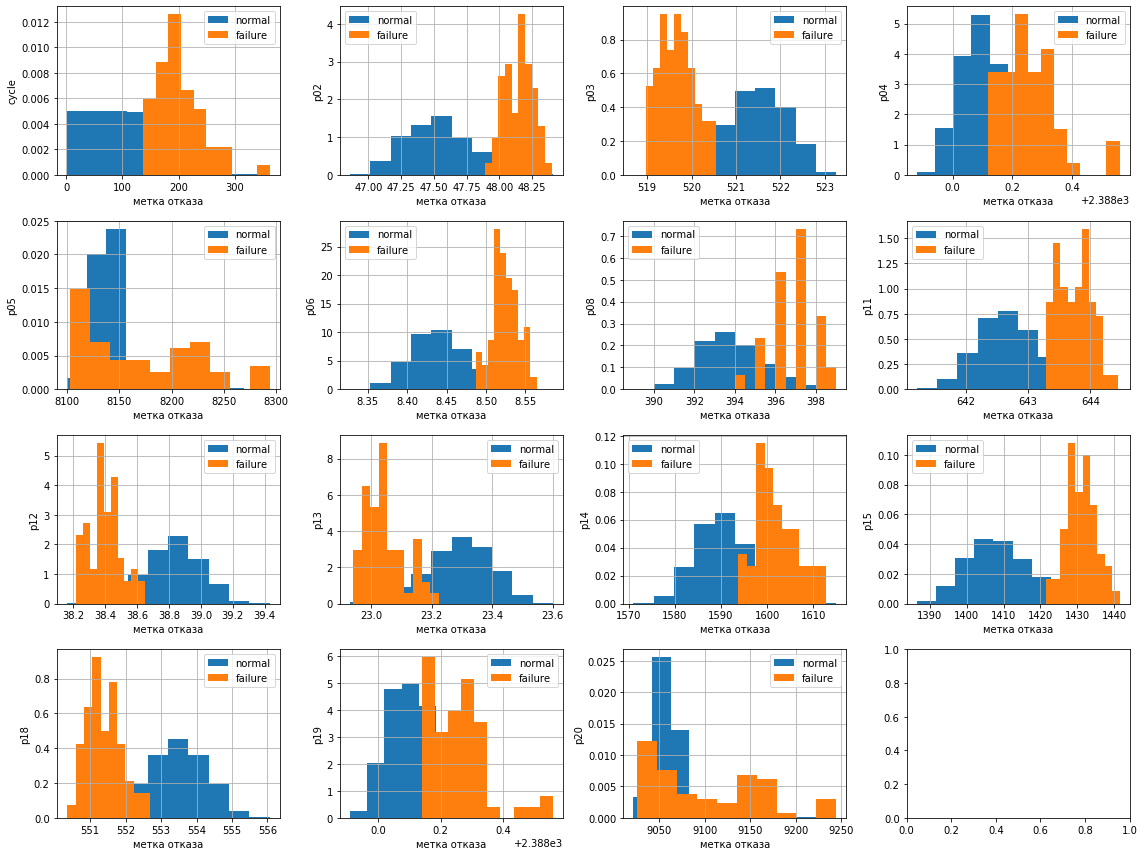

In [14]:
features_false = train[train['target'] == 0].iloc[:, :-1]
features_true = train[train['target'] == 1].iloc[:, :-1]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))

# как вариант, можно и по-другому
for idx, col in enumerate(features_false.columns):
    ax = axes[idx // 4, idx % 4]
    features_false[col].hist(ax=ax, label='normal', density=True)
    features_true[col].hist(ax=ax, label='failure', density=True)
#     ax.plot([0, 1], [features_false[col].mean(), features_true[col].mean()])
    ax.set(xlabel='метка отказа', 
           ylabel=col)
    ax.legend()
fig.tight_layout()

In [15]:
print('{} случаев отказа из {} циклов'.format(len(features_true), len(features)))

60 случаев отказа из 12106 циклов


<a id="data_sep"></a>
## Разделение данных на классы

Теперь попробуем разделить данные на классы

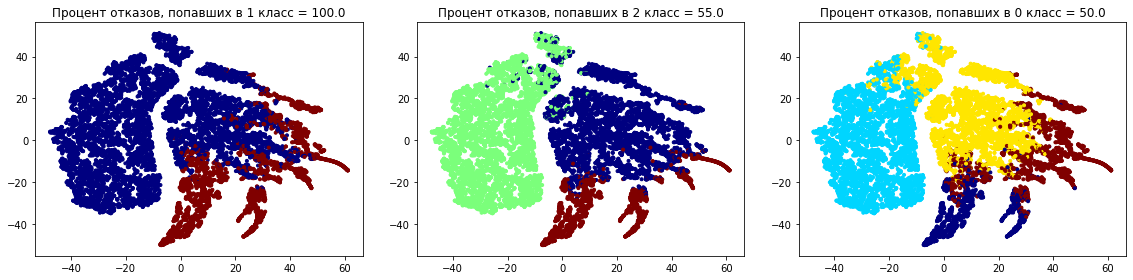

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i, n_cl in enumerate(range(2, 5)):
    gs = GaussianMixture(n_components=n_cl)
    gs.fit(train.iloc[:, :-1])
    classes = gs.predict(train.iloc[:, :-1])
    axes[i].scatter(vis_x, vis_y, c=classes, cmap=plt.cm.get_cmap("jet", n_cl), marker='.')
#     plt.colorbar(ticks=range(n_cl), ax=axes[i])
    prec = []
    for j in range(n_cl):
        prec.append(np.logical_and(classes == j, train.target == 1).sum() / (train.target == 1).sum())
    top_class = np.argmax(prec)
    axes[i].set(title='Процент отказов, попавших в {} класс = {:.1f}'.format(top_class, prec[top_class] * 100))
fig.tight_layout()

In [17]:
gs = GaussianMixture(n_components=2)
gs.fit(train.iloc[:, :-1])
classes = gs.predict(train.iloc[:, :-1])
prec = []
for j in range(2):
    prec.append(np.logical_and(classes == j, train.target == 1).sum() / (train.target == 1).sum())
top_class = np.argmax(prec)
print('Процент отказов, попавших в {} класс = {:.1f}'.format(top_class, prec[top_class] * 100))
print('Доля данных, попавших в класс {} = {:.3f}'.format(top_class, (classes == top_class).sum() / classes.size))
print('Получаем на обучающей выборке {} отказов на {} циклов'.format((train.target == 1).sum(),(classes == top_class).sum()))

Процент отказов, попавших в 1 класс = 100.0
Доля данных, попавших в класс 1 = 0.252
Получаем на обучающей выборке 60 отказов на 3045 циклов


Разделение на классы несколько отличается от ожидаемого. При этом самым эффективным оказалось разделение на 2 класса. В случае такого разделения получаем, что все отказные циклы попали в 1 класс и размер этого класса составляет всего 30% от данных.

Проверим, как себя покажет такое разделение на тестовой выборке:

In [18]:
classes = gs.predict(test.iloc[:, :-1])
prec = np.logical_and(classes == top_class, test.target == 1).sum() / (test.target == 1).sum()
print('Процент отказов, попавших в {} класс = {:.1f}'.format(top_class, prec * 100))
print('Доля данных, попавших в класс {} = {:.3f}'.format(top_class, (classes == top_class).sum() / classes.size))
print('Получаем на тестовой выборке {} отказов на {} циклов'.format((test.target == 1).sum(),(classes == top_class).sum()))

Процент отказов, попавших в 1 класс = 100.0
Доля данных, попавших в класс 1 = 0.244
Получаем на тестовой выборке 20 отказов на 983 циклов


Получаем аналогичный результат. Значит такую кластеризацию можно использовать как первый этап обработки данных.

Вообще в задаче выборки сильно несбалансированны поэтому можно применить oversamling для пополнения выборки.

In [19]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=17)

In [20]:
# Выборки исходных размеров с урезанными признаками.
X_train, y_train = train.iloc[:, :-1], train['target']
X_test, y_test = test.iloc[:, :-1], test['target']
# Oversampling исходных выборок с урезанными признаками.
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
# Усечённые выборки, после разделения на классы
gauss_mix = GaussianMixture(n_components=2)
gauss_mix.fit(train.iloc[:, :-1])
classes = gauss_mix.predict(train.iloc[:, :-1])
prec = []
for j in range(2):
    prec.append(np.logical_and(classes == j, train.target == 1).sum() / (train.target == 1).sum())
top_class = np.argmax(prec)
cut_indices = classes == top_class
test_classes = gauss_mix.predict(test.iloc[:, :-1])
test_cut_indices = test_classes == top_class

X_train_cut, y_train_cut = train.iloc[cut_indices, :-1], train.target[cut_indices]
X_test_cut, y_test_cut = test.iloc[test_cut_indices, :-1], test.target[test_cut_indices]

# Oversampling усечённых выборок
X_train_cut_res, y_train_cut_res = ros.fit_resample(X_train_cut, y_train_cut)

# Предложение 1

## Random forest

**Для начала попробуем применить случайный лес на исходных данных**

In [21]:
%%time
forest = RandomForestClassifier(n_estimators=1000, random_state=17, n_jobs=-1)
scores = cross_val_score(forest, X_train_res, y_train_res, cv=skf)
print('mean accuracy = {:.3f}'.format(scores.mean()))

mean accuracy = 0.999
CPU times: user 3.5 s, sys: 245 ms, total: 3.74 s
Wall time: 9.93 s


Средняя точность достаточно высока, но помня о несбаллансированности классов посмотрим на точность и полноту классификатора.

In [22]:
forest.fit(X_train_res, y_train_res)
y_predict = forest.predict(X_test)
print_pr(y_test, y_predict)

Precision = 0.000, Recall = 0.000, F-score = 0.000


In [23]:
y_predict.sum()

3.0

Классификатор получился почти константным и бесполезным на тестовых данных.

## SVM

**Попробуем метод опорных векторов.**

In [24]:
svm = LinearSVC(random_state=17)
svm.fit(X_train_res, y_train_res)
y_predict = svm.predict(X_test)
print_pr(y_test, y_predict)

Precision = 0.055, Recall = 1.000, F-score = 0.104


Такой классификатор даёт более положительные результаты. Посмотрим его работу на выборке после разделения по классам.

In [25]:
# svm.fit(X_train_cut_res, y_train_cut_res)
y_predict_cut = svm.predict(X_test_cut)
y_predict = np.zeros(y_test.size)
y_predict[test_cut_indices] = y_predict_cut
print_pr(y_test, y_predict)

Precision = 0.056, Recall = 1.000, F-score = 0.107


Чуть лучший результат, но улучшение несущественно.

## SGD

**Попробуем ещё логистическую регрессию**

In [26]:
%%time
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train_res, y_train_res)
y_predict = sgd_logit.predict(X_test)
print_pr(y_test, y_predict)

Precision = 0.035, Recall = 1.000, F-score = 0.068
CPU times: user 241 ms, sys: 3.98 ms, total: 245 ms
Wall time: 244 ms


Результаты не лучше. Получается, что наилучшим классификатором является SVM с последующим отделением класса потенциально критических циклов.

Хоть такой классификатор и даёт много ложных срабатываний, при этом он находит все критические циклы.

# Предложение 2

<a id="data_rebuild"></a>
## Перестроение пространства признаков

Предположим, что отказ моторо явление, которое можно предсказать не по одному, а по нескольким предшествующим циклам. Тогда расширим признаковое пространство, добавив в него показания с предыдущих циклов.

In [27]:
def rebuild_data(df, cycles):
    y = df.target.to_numpy()
    X = df.iloc[:, :-1].to_numpy()
    olen, flen = X.shape
    if cycles > y.size:
        return X.reshape(1, -1), np.array([1])
    
    X_new = np.zeros((olen - cycles + 1, flen * cycles))
    for i in range(y.size - cycles + 1):
        X_new[i, :] = X[i:i + cycles, :].reshape(-1)
    y_new = y[cycles - 1:]
    return X_new, y_new   

In [28]:
X_train_ext, y_train_ext = rebuild_data(train, 4)

## Кластеризация

In [29]:
%%time
features = X_train_ext
target = y_train_ext
embeddings = TSNE(n_jobs=-1).fit_transform(features)
vis_x_ext = embeddings[:, 0]
vis_y_ext = embeddings[:, 1]

CPU times: user 1min 35s, sys: 149 ms, total: 1min 35s
Wall time: 27.2 s


Попробуем также отделить класс критических последовательностей.

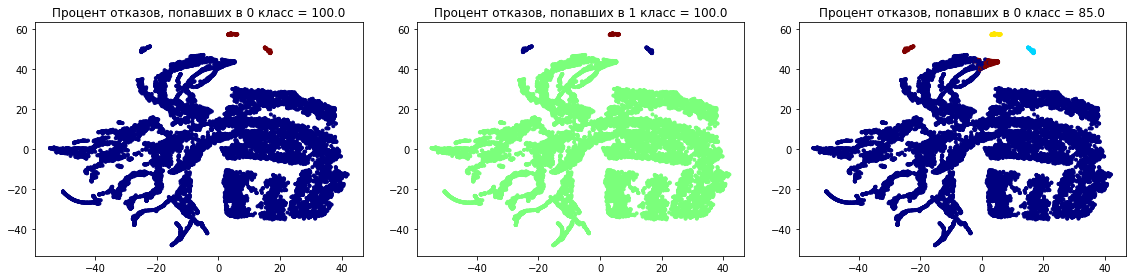

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i, n_cl in enumerate(range(2, 5)):
    gs = GaussianMixture(n_components=n_cl)
    gs.fit(X_train_ext)
    classes = gs.predict(X_train_ext)
    axes[i].scatter(vis_x_ext, vis_y_ext, c=classes, cmap=plt.cm.get_cmap("jet", n_cl), marker='.')
#     plt.colorbar(ticks=range(n_cl), ax=axes[i])
    prec = []
    for j in range(n_cl):
        prec.append(np.logical_and(classes == j, y_train_ext == 1).sum() / (y_train_ext == 1).sum())
    top_class = np.argmax(prec)
    axes[i].set(title='Процент отказов, попавших в {} класс = {:.1f}'.format(top_class, prec[top_class] * 100))
fig.tight_layout()

Видно, что такая структура плохо разделима. Поэтому попробуем просто различные размеры последовательностей с классификатором SVM

<a id="best_estimator"></a>
## Классификация

In [31]:
svm = LinearSVC(random_state=17)
for cycles in range(2, 16):
    X_train_ext, y_train_ext = rebuild_data(train, cycles)
    X_test_ext, y_test_ext = rebuild_data(test, cycles)
    
    X_train_ext_res, y_train_ext_res = ros.fit_resample(X_train_ext, y_train_ext)
    
    svm.fit(X_train_ext_res, y_train_ext_res)
    y_predict = svm.predict(X_test_ext)
    print('For sequence of {} cycles result is:'.format(cycles))
    print_pr(y_test_ext, y_predict)

For sequence of 2 cycles result is:
Precision = 0.172, Recall = 1.000, F-score = 0.294
For sequence of 3 cycles result is:
Precision = 0.043, Recall = 1.000, F-score = 0.083
For sequence of 4 cycles result is:
Precision = 0.069, Recall = 1.000, F-score = 0.129
For sequence of 5 cycles result is:
Precision = 0.056, Recall = 1.000, F-score = 0.106
For sequence of 6 cycles result is:
Precision = 0.048, Recall = 1.000, F-score = 0.092
For sequence of 7 cycles result is:
Precision = 0.074, Recall = 1.000, F-score = 0.138
For sequence of 8 cycles result is:
Precision = 0.049, Recall = 1.000, F-score = 0.093
For sequence of 9 cycles result is:
Precision = 0.113, Recall = 1.000, F-score = 0.203
For sequence of 10 cycles result is:
Precision = 0.051, Recall = 1.000, F-score = 0.096
For sequence of 11 cycles result is:
Precision = 0.054, Recall = 1.000, F-score = 0.102
For sequence of 12 cycles result is:
Precision = 0.172, Recall = 1.000, F-score = 0.294
For sequence of 13 cycles result is:
Pre

Видно, что качество действительно зависит от количества циклов. Проверим результаты на нескольких различных разбиениях.

In [44]:
def cross_score(data, svm, cv=3, max_cycles=10):
    random.seed(17)
    cycles_range = np.array(range(2, max_cycles + 1))
    precision = np.zeros((cv, cycles_range.size))
    recall = np.zeros((cv, cycles_range.size))
    f_score = np.zeros((cv, cycles_range.size))
    for i in range(cv):
        idx_set = random.sample(range(1, 80), 20)
        indices = data['id'] == idx_set[0]
        for k in idx_set[1:]:
            indices = indices | (data['id'] == k)

        train = new_data[~indices]
        test = new_data[indices]
        
        for j, cycles in enumerate(cycles_range):
            X_train_ext, y_train_ext = rebuild_data(train, cycles)
            X_test_ext, y_test_ext = rebuild_data(test, cycles)

            X_train_ext_res, y_train_ext_res = ros.fit_resample(X_train_ext, y_train_ext)

            svm.fit(X_train_ext_res, y_train_ext_res)
            y_predict = svm.predict(X_test_ext)
            prec, rec, f, _ = precision_recall_fscore_support(y_test_ext, y_predict, labels=[1])
            precision[i, j] = prec[0]
            recall[i, j] = rec[0]
            f_score[i, j] = f[0]
    
    return cycles_range, precision, recall, f_score

In [45]:
def plot_validation_curves(param_values, score, ax=None):
    mean_curve = score.mean(axis=0)
    min_curve = score.min(axis=0)
    max_curve = score.max(axis=0)
    
    mean_line = plt.plot(param_values, mean_curve, '-', color='red')
    plt.fill_between(param_values, min_curve, max_curve, edgecolor='none',
                     facecolor=mean_line[0].get_color(), alpha=0.2)

In [46]:
cycles, prec, rec, f = cross_score(data, svm)

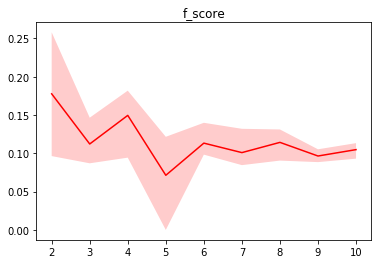

In [47]:
plot_validation_curves(cycles, f)
plt.title('f_score');

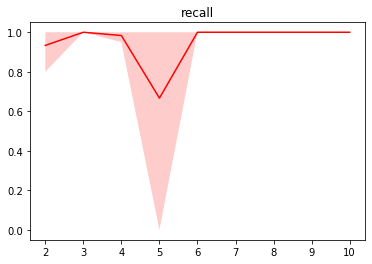

In [48]:
plot_validation_curves(cycles, rec)
plt.title('recall');

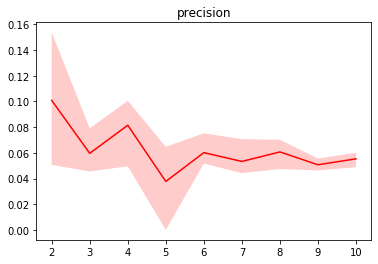

In [49]:
plot_validation_curves(cycles, prec)
plt.title('precision');

Похоже, что оптимальным количеством циклов является 4.

Так же попробуем отсеять из данных, полученных классификатором те, что не могут являться отказными последовательностями в силу [разделения на классы](#data_sep)

In [50]:
svm = LinearSVC(random_state=17)
cycles = 4

X_train_ext, y_train_ext = rebuild_data(train, cycles)
X_train_ext_res, y_train_ext_res = ros.fit_resample(X_train_ext, y_train_ext)

X_test_ext, y_test_ext = rebuild_data(test, cycles)

svm.fit(X_train_ext_res, y_train_ext_res)
y_predict = svm.predict(X_test_ext)
print('scores before clustering')
print_pr(y_test_ext, y_predict)

y_predict[~test_cut_indices[cycles - 1:]] = 0
print('scores after clustering')
print_pr(y_test_ext, y_predict)

scores before clustering
Precision = 0.069, Recall = 1.000, F-score = 0.129
scores after clustering
Precision = 0.070, Recall = 1.000, F-score = 0.130


Видно, что дополнительный отсев данных преимущества практически не даёт.

# Вывод

Таким образом наилучшей моделью по предсказанию отказа мотора на следующем цикле является следующий алгоритм:
* [отсев](#data_preproc) параметров ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 's1', 's2'] как не несущих смысловой нагрузки при решении задачи
* [преобразование](#data_rebuilding) пространства признаков путём выделения последовательностей из 6 циклов
* oversampling выборки на котрой будет обучаться классификатор
* Обучение [SVM](#best_estimator)-классификатора на подготовленной выборке